# Packages

The cell below contains the packages that are used in the code.

In [1]:
from mesa.batchrunner import BatchRunner
from IconicityModel import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# BatchRunner

## Helper functions

Runs the batchrunner for a certain amount of episodes and steps.

In [2]:
def run_batchrunner(model, fixed_pm, variable_pm, nb_iterations, nb_steps):
    batch_run = BatchRunner(model,
                           variable_pm,
                           fixed_pm,
                           iterations = nb_iterations,
                           max_steps = nb_steps,
                           model_reporters = {"Data Collector": lambda m: m.datacollector})
    batch_run.run_all()
    return batch_run.get_model_vars_dataframe()

In [3]:
def calculate_average_agent_data_per_iteration(data, pm_values, nb_iterations):
    avg_data_per_pm = []
    max_data_per_pm = []
    min_data_per_pm = []
    
    for i in range(0, nb_iterations * len(pm_values), nb_iterations):
        iteration_df = data[i:i + nb_iterations]
        data_collector_dfs = [dc.get_model_vars_dataframe() for dc in iteration_df["Data Collector"].tolist()]
        
        avg_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).mean()
        max_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).max()
        min_data_per_iteration = pd.concat(data_collector_dfs).groupby(level=0).min()
        
        avg_data_per_pm.append(avg_data_per_iteration)
        max_data_per_pm.append(max_data_per_iteration)
        min_data_per_pm.append(min_data_per_iteration)
        
    
    return avg_data_per_pm, max_data_per_pm, min_data_per_pm

In [4]:
def plot_data(avg_data, max_data, min_data, pm_values, pm_name):
    l1_means = []
    l2_means = []
    total_means = []
    l1_maxs = []
    l2_maxs = []
    total_maxs = []
    l1_mins = []
    l2_mins = []
    total_mins = []
    
    # draw the agent data per step for each parameter value
    for i in range(len(pm_values)):
        fig, ax = plt.subplots(figsize=(10, 4))
        pm_value = pm_values[i]
        pm_data = avg_data[i]
        
        # L1 avg iconicity
        y_avg = avg_data[i]["l1_avg_iconicity"].to_numpy()
        y_max = max_data[i]["l1_avg_iconicity"].to_numpy()
        y_min = min_data[i]["l1_avg_iconicity"].to_numpy()
        x = np.arange(len(y_avg))
        
        ax.plot(x, y_avg, color='green', label='L1 avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='green', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        l1_means.append(y_avg[-1])
        l1_maxs.append(y_max[-1])
        l1_mins.append(y_min[-1])
        
        # L2 avg iconicity
        y_avg = avg_data[i]["l2_avg_iconicity"].to_numpy()
        y_max = max_data[i]["l2_avg_iconicity"].to_numpy()
        y_min = min_data[i]["l2_avg_iconicity"].to_numpy()
        
        ax.plot(x, y_avg, color='red', label='L2 avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='red', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        l2_means.append(y_avg[-1])
        l2_maxs.append(y_max[-1])
        l2_mins.append(y_min[-1])
        
        # Total avg iconicity
        y_avg = avg_data[i]["total_avg_iconicity"].to_numpy()
        y_max = max_data[i]["total_avg_iconicity"].to_numpy()
        y_min = min_data[i]["total_avg_iconicity"].to_numpy()
        
        ax.plot(x, y_avg, color='black', label='Total avg. iconicity level', linewidth = 1.0)
        ax.fill_between(x, y_min, y_max, color='black', alpha=0.2)
        
        # Store end (last step) results for 2nd plot | index -1 is last element of array
        total_means.append(y_avg[-1])
        total_maxs.append(y_max[-1])
        total_mins.append(y_min[-1])
        
        # General plot properties
        ax.grid(b=True, axis='both')
        ax.set_ylim([0,100])
        ax.set_xlim([0,len(x)-1])
        ax.set_xticks(range(0, len(x), 5))
        ax.set_title("Average iconicity level for " + str(pm_name) + " = " + str(pm_value))
        ax.set_ylabel("Average iconicity level")
        ax.set_xlabel("Steps")
        ax.legend()
        
    labels = ["L1 signers", "L2 signers", "all signers"]
    colors = ['green', 'red', 'gray']
    end_results = [[l1_means, l1_maxs, l1_mins], [l2_means, l2_maxs, l2_mins], [total_means, total_maxs, total_mins]]
             
    # draw the model results for each parameter value
    for i in range(3):
        plt.figure(i)
        color = colors[i]
        
        x = np.asarray(pm_values)
        y = end_results[i]
        y_mean = np.asarray(y[0])
        y_max = np.asarray(y[1])
        y_min = np.asarray(y[2])
        
        plt.errorbar(x, y_mean,
                        yerr=[y_mean - y_min, y_max - y_mean],
                        fmt='none',
                        ecolor='black',
                        capsize=3.0,
                        capthick=2.0,
                        lw=1,
                        color=color)
        plt.bar(x, y_mean, width=8, color=color,alpha=0.6)
    
        plt.xticks(x)
        plt.yticks(np.arange(0, 120, 20))
    
        plt.title("Resulting avg. iconicity level for " + labels[i] + " after 50 steps")
        plt.xlabel(pm_name)
        plt.ylabel("Average iconicity level")
    
        plt.show()

## Parameter exploration

### L2 replace chance

First we try several proportions for the replacement policy. Each value represents the chance of an agent being replaced by an L2 agent.

30it [11:44, 23.50s/it]


STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration
 - Data from running the model for 10 iteration(s) for each parameter value:


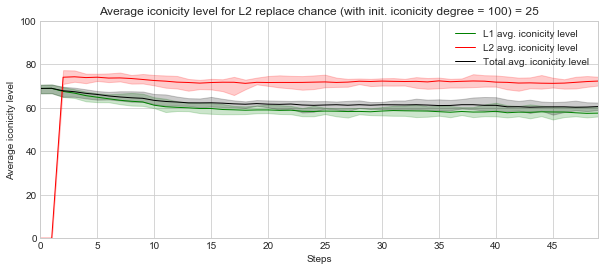

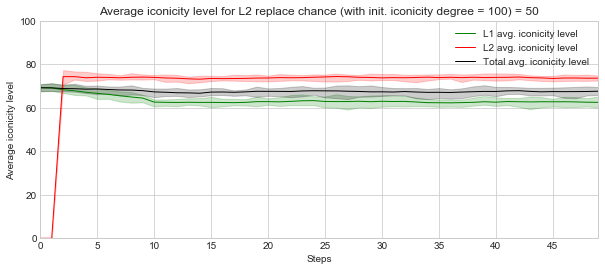

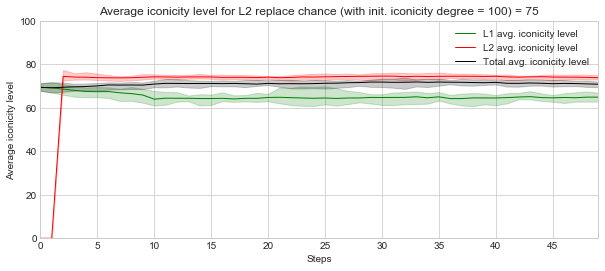

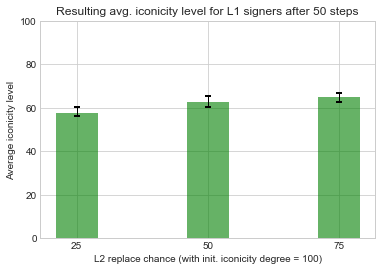

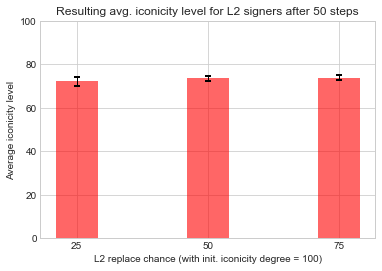

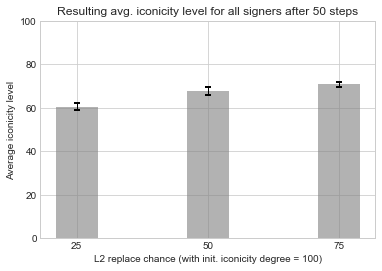

30it [11:38, 23.29s/it]


STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration
 - Data from running the model for 10 iteration(s) for each parameter value:


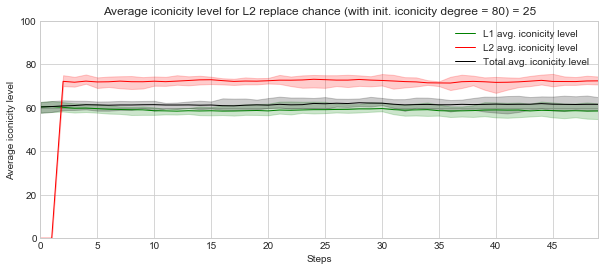

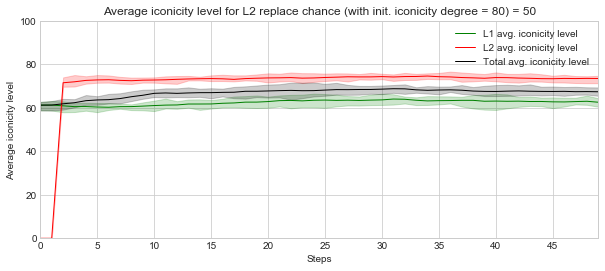

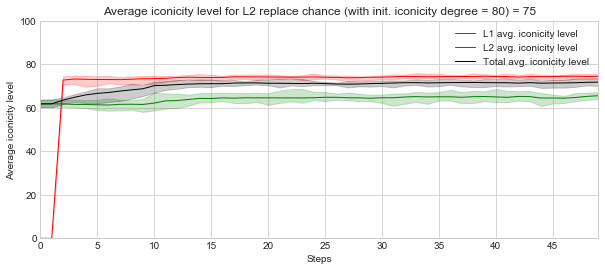

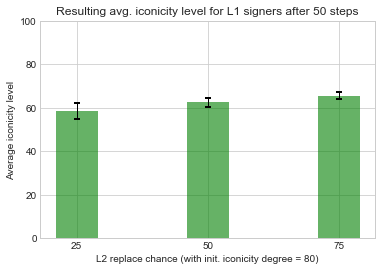

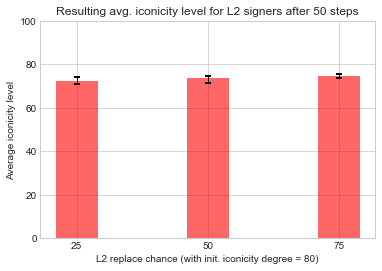

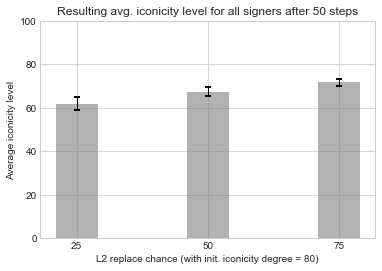

30it [12:17, 24.59s/it]


STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration
 - Data from running the model for 10 iteration(s) for each parameter value:


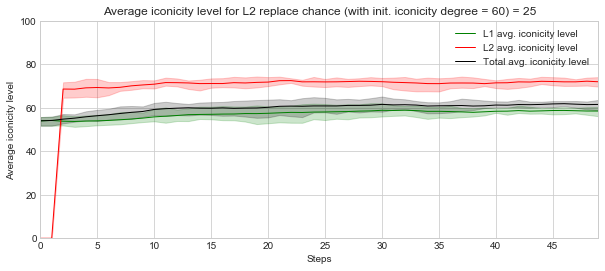

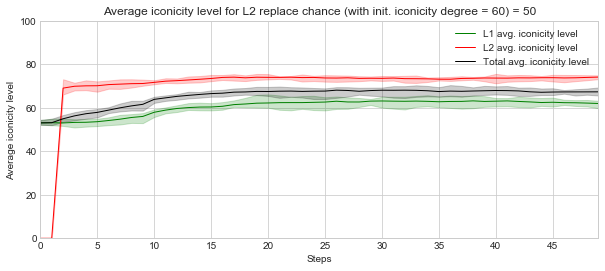

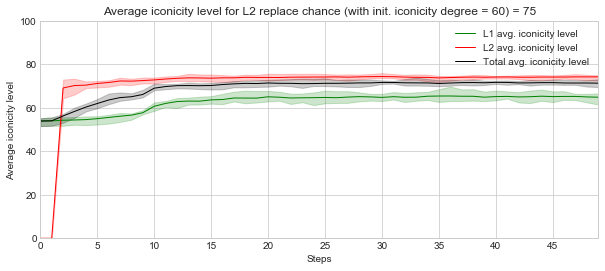

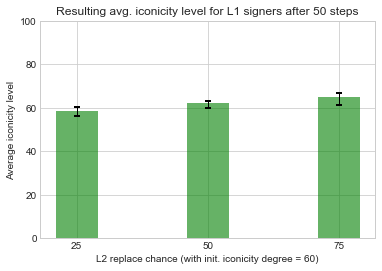

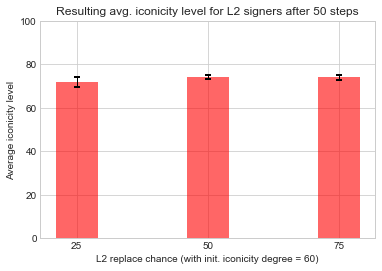

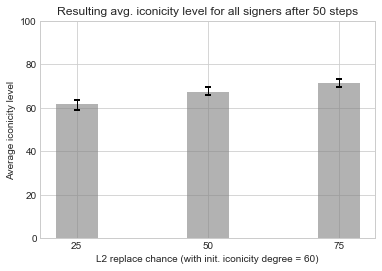

30it [11:36, 23.23s/it]


STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration
 - Data from running the model for 10 iteration(s) for each parameter value:


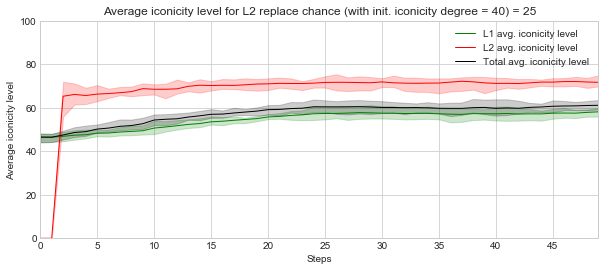

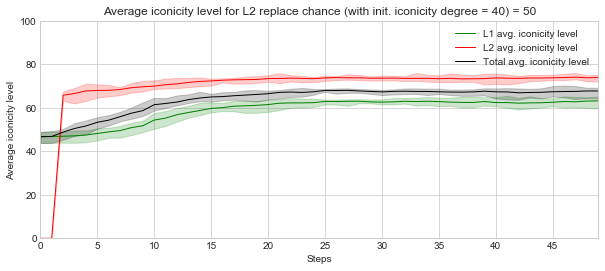

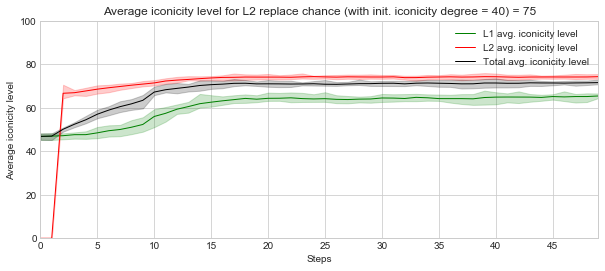

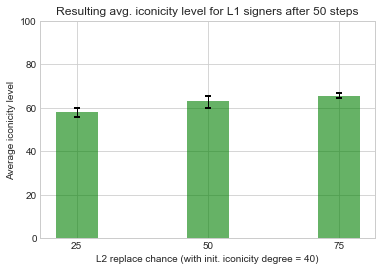

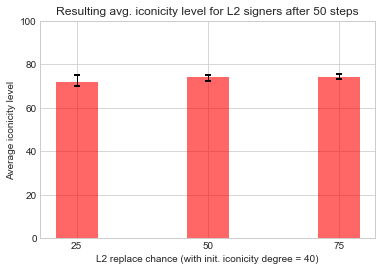

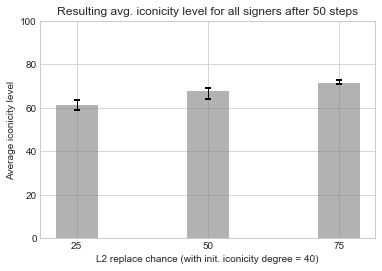

30it [11:06, 22.22s/it]


STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration
 - Data from running the model for 10 iteration(s) for each parameter value:


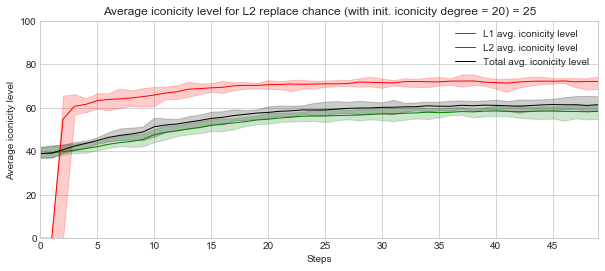

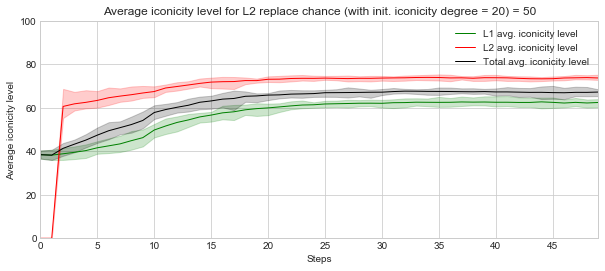

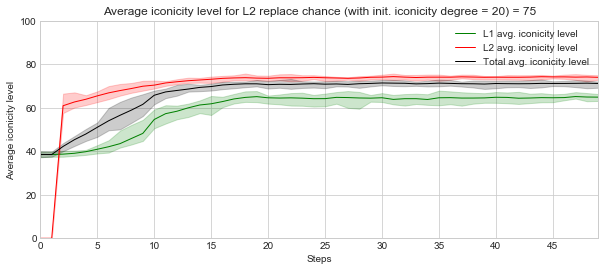

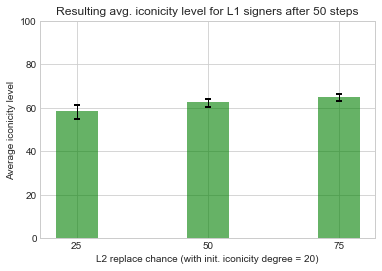

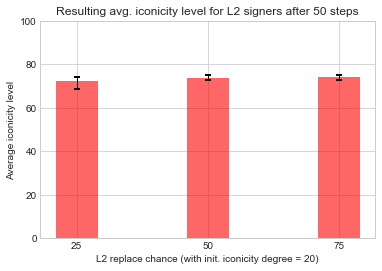

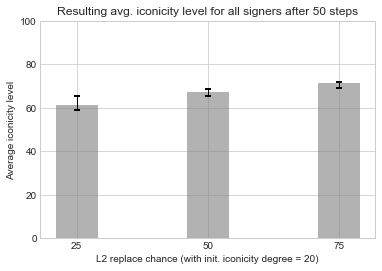

In [5]:
# define the values of the variable pm and amount of iterations and steps per iteration
proportions = [25, 50, 75]
nb_iterations = 10
nb_steps = 50

initial_iconicity_degrees = [100, 80, 60, 40, 20]

for initial_iconicity_degree in initial_iconicity_degrees:
    # define the fixed and variable parameters
    fixed_pm = {"width": 10,
                "height": 10,
                "vocab_size": 10, 
                "word_length": 5,
                "turnover_chance": 20,
                "turnover_threshold": 10,
                "initial_degree_of_iconicity": initial_iconicity_degree,
                "learning_error_degree": 20,
                "l2_radius": 100}
    variable_pm = {"l2_replace_chance": proportions}

    # run the batchrunner
    df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

    # print the statistics
    print("STATISTICS FOR L2 REPLACEMENT CHANCE PARAMETER EXPLORATION")
    print(" - Possible values: " + str(proportions))
    print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration")
    print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")
    
    avg, maxi, mini = calculate_average_agent_data_per_iteration(df, proportions, nb_iterations)
    plot_data(avg, maxi, mini, proportions, "L2 replace chance (with init. iconicity degree = " + str(initial_iconicity_degree) + ")")

### L2 radius

Then we try several radiuses from which an L2 learner can acquire signs from.

In [6]:
# define the values of the variable pm and amount of iterations and steps per iteration
radiuses = [1, 25, 50, 75, 100]
nb_iterations = 10
nb_steps = 50

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10,
            "word_length": 5,
            "turnover_chance": 20,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "learning_error_degree": 20,
            "l2_replace_chance": 50}
variable_pm = {"l2_radius": radiuses}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR L2 LEARNING RADIUS PARAMETER EXPLORATION")
print(" - Possible values: " + str(radiuses))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

50it [07:01,  8.43s/it]

STATISTICS FOR L2 LEARNING RADIUS PARAMETER EXPLORATION
 - Possible values: [1, 25, 50, 75, 100]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


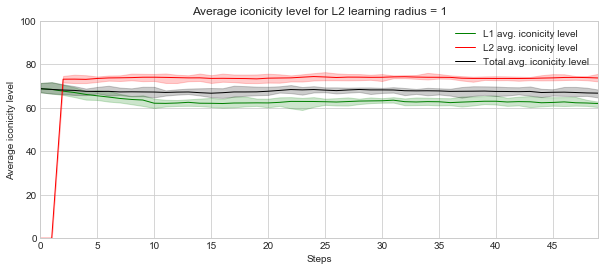

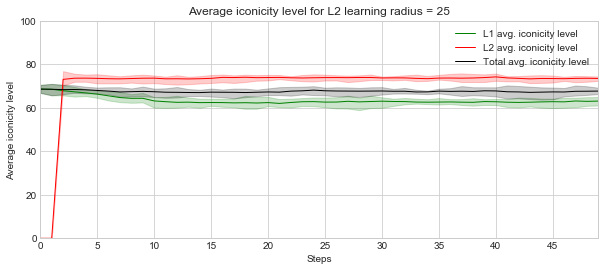

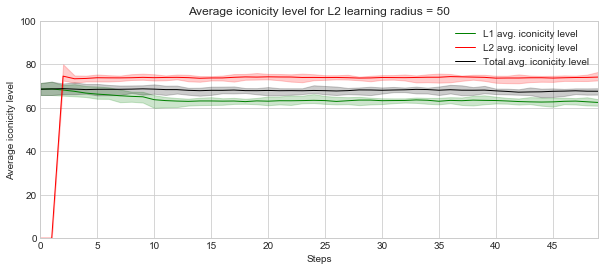

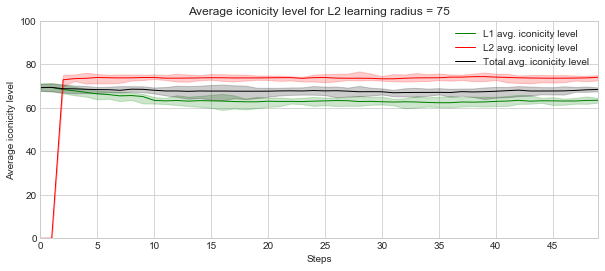

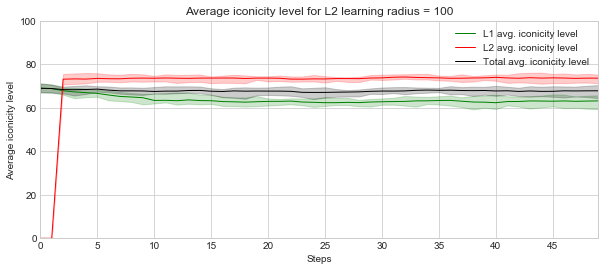

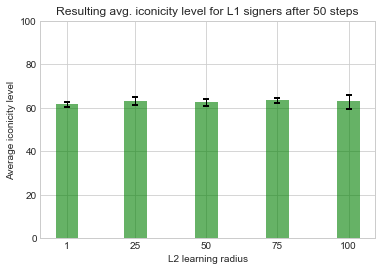

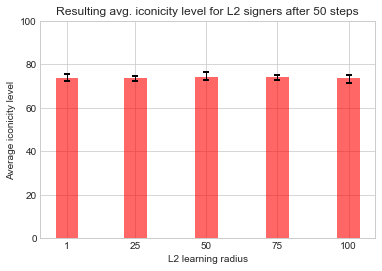

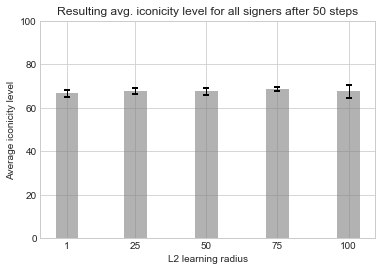

In [7]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, radiuses, nb_iterations)
plot_data(avg, maxi, mini, radiuses, "L2 learning radius")

### Turnover chance

Then we try the turnover chance of the agents. This will determine the chance of an agent dying when it has reached age 2 or higher.

14it [07:10, 39.54s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


20it [11:33, 43.28s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


21it [12:34, 48.44s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


22it [13:34, 52.01s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


23it [14:34, 54.48s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


24it [15:36, 56.79s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


26it [17:35, 57.85s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


27it [18:34, 58.34s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


28it [19:34, 58.89s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


29it [20:38, 60.35s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


30it [21:41, 43.39s/it]


STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


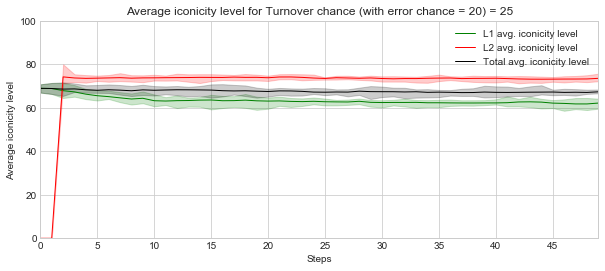

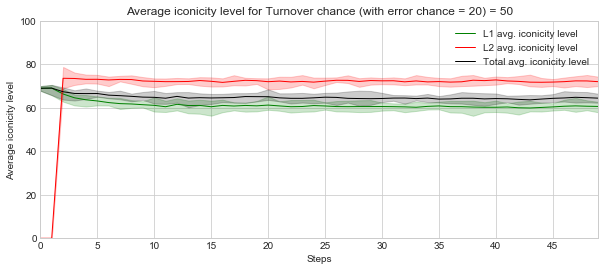

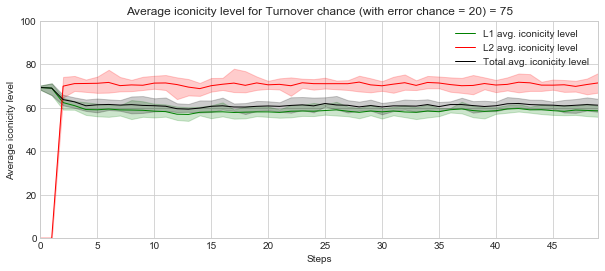

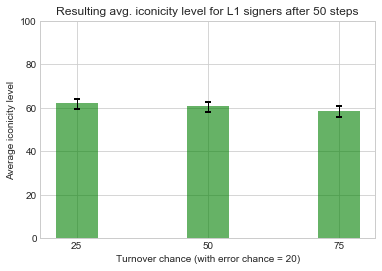

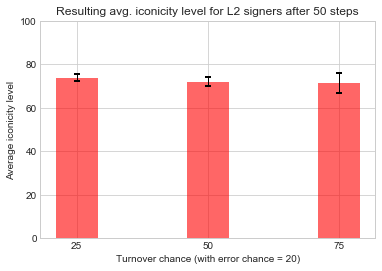

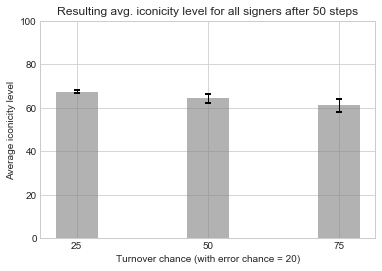

11it [05:09, 32.43s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


13it [06:43, 39.63s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


15it [08:16, 43.44s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


20it [12:00, 44.05s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


21it [13:00, 48.75s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


22it [13:59, 51.91s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


23it [14:59, 54.39s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


24it [16:01, 56.70s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


25it [17:03, 58.21s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


26it [18:01, 58.11s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


27it [19:02, 59.10s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


28it [20:02, 59.13s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


29it [21:04, 60.22s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


30it [22:04, 44.16s/it]


STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


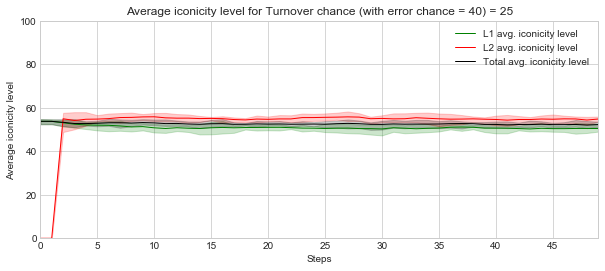

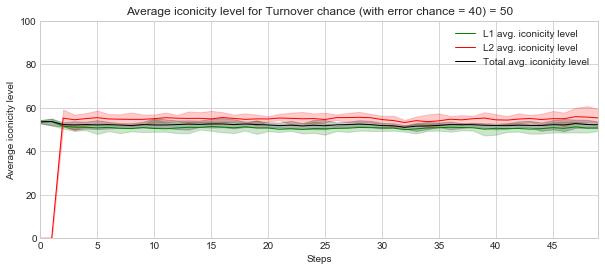

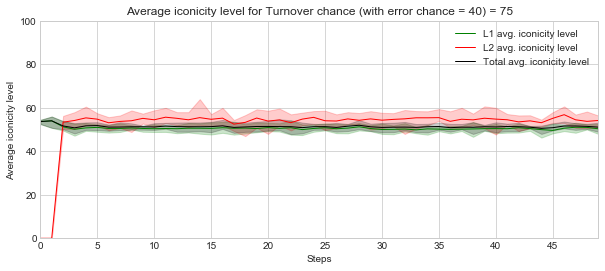

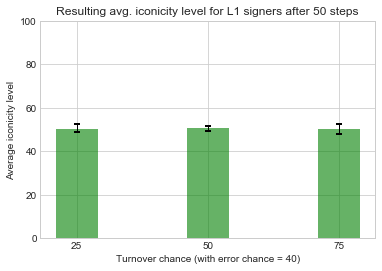

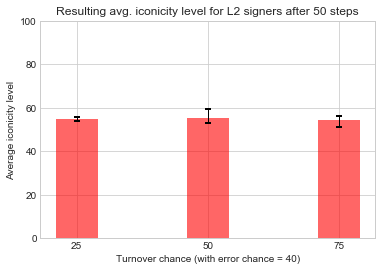

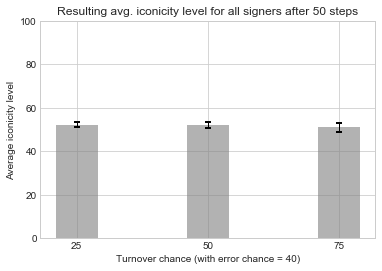

20it [11:29, 43.13s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


21it [12:31, 48.65s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


22it [13:32, 52.57s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


23it [14:37, 56.03s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


24it [15:36, 57.21s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


25it [16:40, 59.20s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


26it [17:39, 59.05s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


27it [18:36, 58.54s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


28it [19:40, 60.17s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


29it [20:44, 61.14s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


30it [21:46, 43.56s/it]


STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


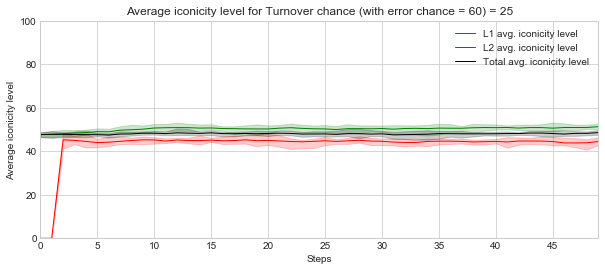

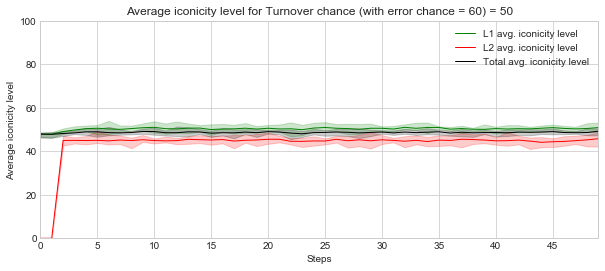

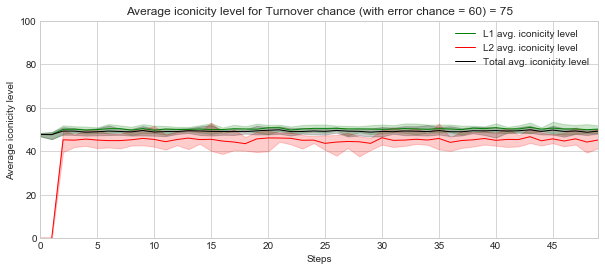

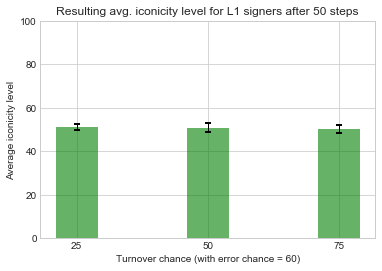

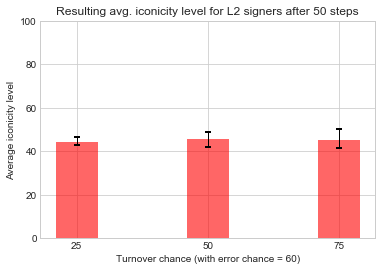

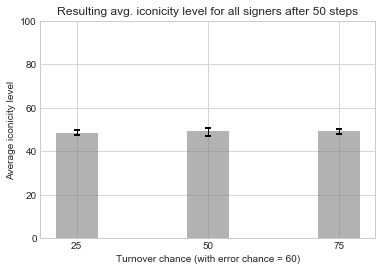

10it [04:16, 25.19s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


14it [07:09, 38.85s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


20it [11:35, 44.35s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


21it [12:39, 50.33s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


23it [14:52, 58.76s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


24it [15:54, 59.69s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


25it [16:54, 59.82s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


26it [17:50, 58.83s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


27it [18:52, 59.83s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


28it [19:49, 58.91s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


29it [20:48, 58.99s/it]

Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from
Agent has no suitable interlocutors to learn from


30it [21:51, 43.73s/it]


STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION
 - Possible values: [25, 50, 75]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


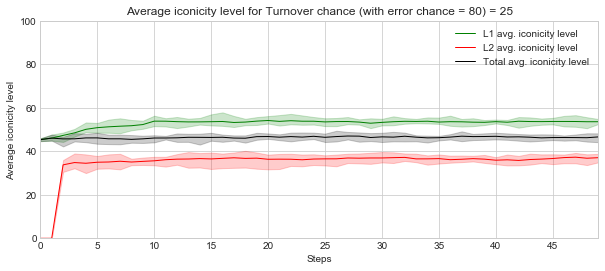

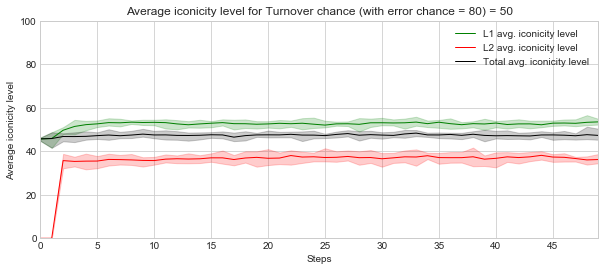

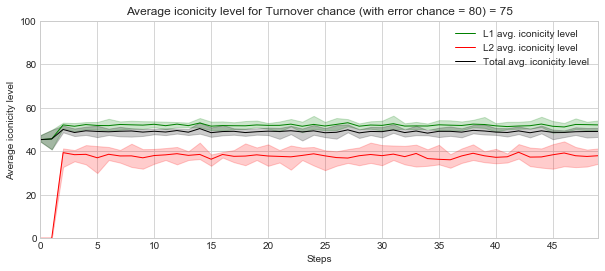

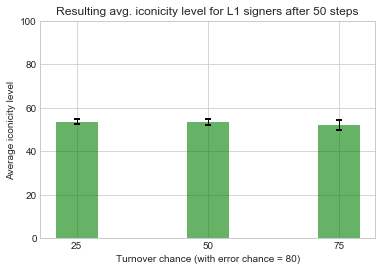

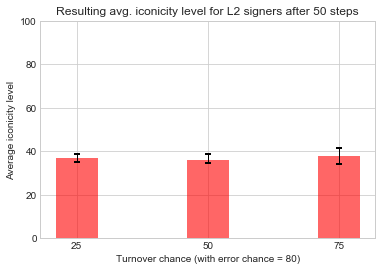

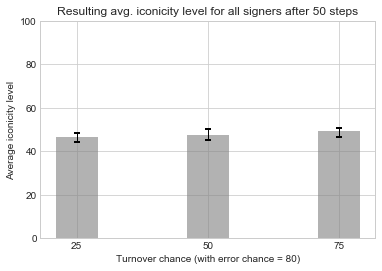

In [8]:
# define the values of the variable pm and amount of iterations and steps per iteration
chances = [25, 50, 75]
nb_iterations = 10
nb_steps = 50

errors = [20, 40, 60, 80]

for error in errors:
    # define the fixed and variable parameters
    fixed_pm = {"width": 10,
                "height": 10,
                "vocab_size": 10,
                "word_length": 5,
                "turnover_threshold": 10,
                "initial_degree_of_iconicity": 100,
                "learning_error_degree": error,
                "l2_radius": 100,
                "l2_replace_chance": 50}
    variable_pm = {"turnover_chance": chances}

    # run the batchrunner
    df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

    # print the statistics
    print("STATISTICS FOR TURNOVER CHANCE PARAMETER EXPLORATION")
    print(" - Possible values: " + str(chances))
    print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
    print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")
    
    avg, maxi, mini = calculate_average_agent_data_per_iteration(df, chances, nb_iterations)
    plot_data(avg, maxi, mini, chances, "Turnover chance (with error chance = " + str(fixed_pm["learning_error_degree"]) + ")")

### Learning error degree

Next up is the learning error degree; we will test various values that determine the error an agent makes while acquiring the phonological component of a sign.

In [9]:
# define the values of the variable pm and amount of iterations and steps per iteration
errors = [0, 20, 40, 60, 80]
nb_iterations = 10
nb_steps = 50

# define the fixed and variable parameters
fixed_pm = {"width": 10,
            "height": 10,
            "vocab_size": 10,
            "word_length": 5,
            "turnover_chance": 20,
            "turnover_threshold": 10,
            "initial_degree_of_iconicity": 100,
            "l2_radius": 100,
            "l2_replace_chance": 50}
variable_pm = {"learning_error_degree": errors}

# run the batchrunner
df = run_batchrunner(IconicityModel, fixed_pm, variable_pm, nb_iterations, nb_steps)

# print the statistics
print("STATISTICS FOR LEARNING ERROR DEGREE PARAMETER EXPLORATION")
print(" - Possible values: " + str(errors))
print(" - Ran for " + str(nb_iterations) + " iteration(s) and " + str(nb_steps) + " steps per iteration\n")
print(" - Data from running the model for " + str(nb_iterations) + " iteration(s) for each parameter value:")

50it [19:03, 22.87s/it]

STATISTICS FOR LEARNING ERROR DEGREE PARAMETER EXPLORATION
 - Possible values: [0, 20, 40, 60, 80]
 - Ran for 10 iteration(s) and 50 steps per iteration

 - Data from running the model for 10 iteration(s) for each parameter value:


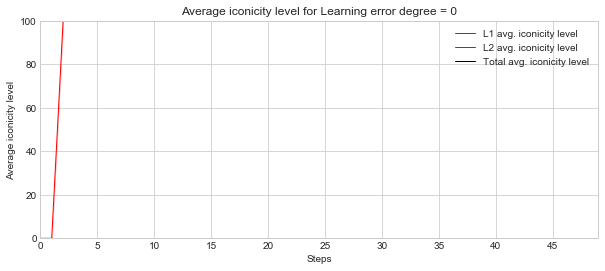

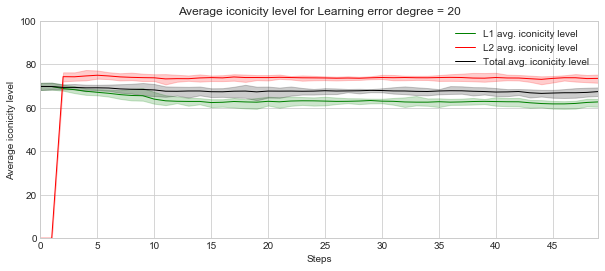

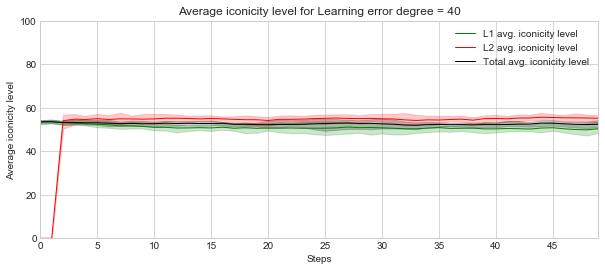

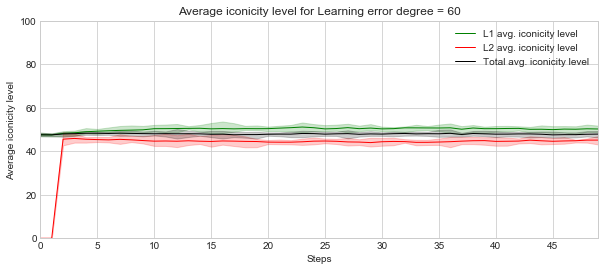

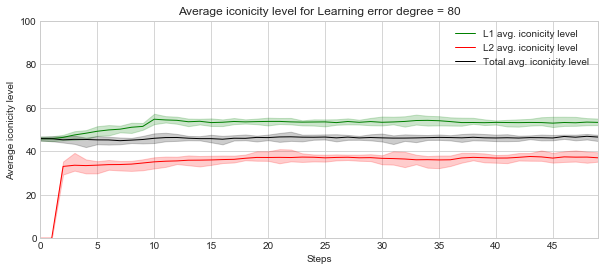

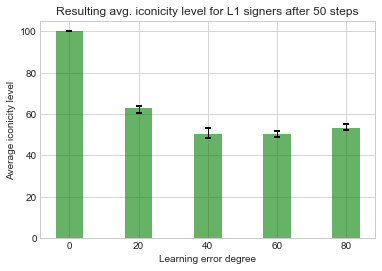

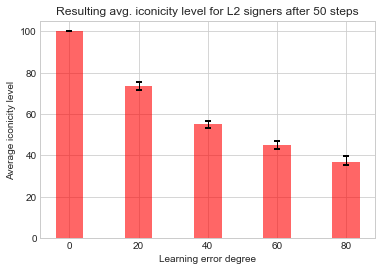

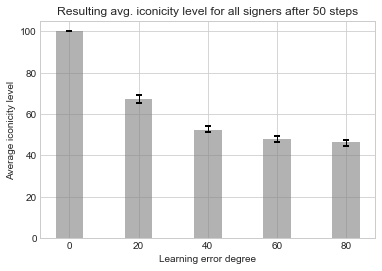

In [10]:
avg, maxi, mini = calculate_average_agent_data_per_iteration(df, errors, nb_iterations)
plot_data(avg, maxi, mini, errors, "Learning error degree")